# Practical Time Series Analysis

## Week 6: Forecasting

**1. Forecasting**

In [48]:
library(forecast)
library(tsdl)

## 1. Forecasting

### 1.1. Simple Exponential Smoothing

In [6]:
rain.data = scan("http://robjhyndman.com/tsdldata/hurst/precip1.dat",skip=1)
rain.ts = ts(rain.data, start=c(1813)) 

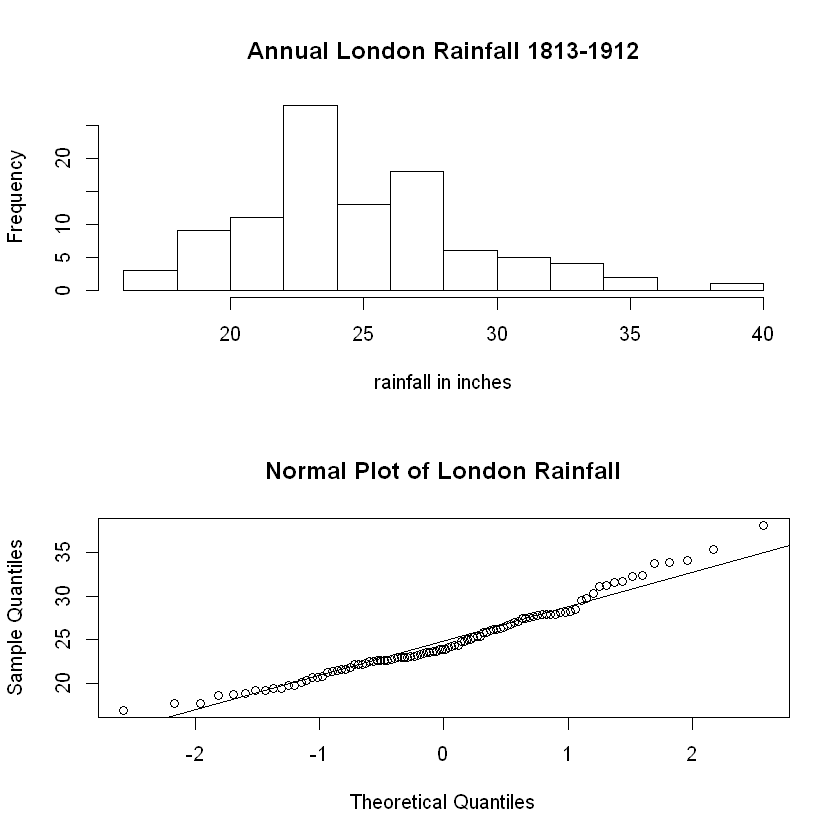

In [8]:
par( mfrow=c(2,1) )
hist(rain.data, main="Annual London Rainfall 1813-1912", xlab="rainfall in inches")
qqnorm(rain.data, main="Normal Plot of London Rainfall")
qqline(rain.data)

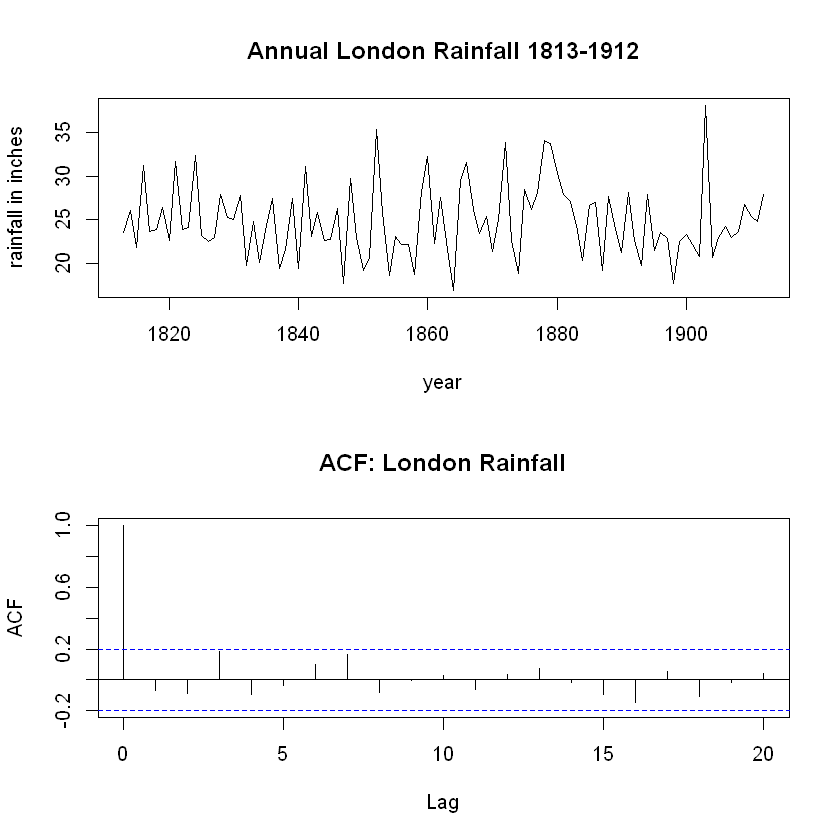

In [9]:
par( mfrow=c(2,1) )
plot.ts(rain.ts, main="Annual London Rainfall 1813-1912", xlab="year", ylab="rainfall in inches")
acf(rain.ts, main="ACF: London Rainfall")

In [11]:
auto.arima(rain.ts)

Series: rain.ts 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
         mean
      24.8239
s.e.   0.4193

sigma^2 estimated as 17.76:  log likelihood=-285.25
AIC=574.49   AICc=574.61   BIC=579.7

In case nothing works, we have those methods:

$x^{n}_{n+h}$

where

* $n$ = time for which you actually have data
* $n + h$ = time for which you would like a forecast

**Naive Method**

$x^{n}_{n+1} = x_n$

**Seasonal Naive Method**

$x^n_{n+1} = x_{n+1-S}$

**Average Method**

$x^n_{n+1} = \frac{\Sigma^n_{i=1} x_i}{n}$

**Simple Exponential Smoothing**

Form a new forecast by:

* Weighting the previous forecast $x_n^{n-1}$
* Updating with the fresh data point $x_n$

Example:

1. $x^1_2 = x_1$
2. $x^2_3 = \alpha \; x_2 + (1-\alpha) \; x^1_2$
3. $x^3_4 = \alpha \; x_3 + (1 - \alpha) \; x^2_3$

$\vdots$

In [47]:
alpha=.024 #increase alpha for more rapid decay
forecast.values = NULL #establish array to store forecast values

n = length(rain.data) 

#naive first forecast 
forecast.values [1] = rain.data[1] 

#loop to create all forecast values
for( i in 1:n ) {
    forecast.values [i+1] = alpha*rain.data[i] + (1-alpha)* forecast.values[i]
}
paste("forecast for time",n+1," = ", forecast.values [n+1])

[1] "forecast for time 101  =  24.6771392918524"

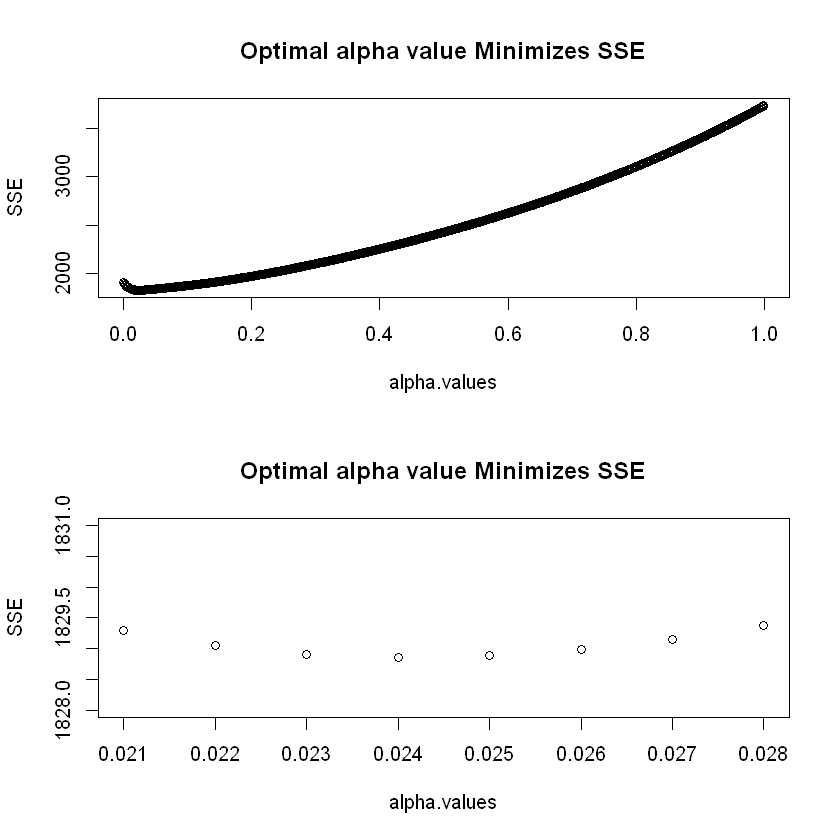

In [44]:
SSE=NULL
n = length(rain.data)
alpha.values = seq( .001, .999, by=0.001)
number.alphas = length(alpha.values)
for( k in 1:number.alphas ) {
    forecast.values=NULL
    alpha = alpha.values[k]
    forecast.values[1] = rain.data[1]
    for( i in 1:n ) {
        forecast.values[i+1] = alpha*rain.data[i] + (1-alpha)*forecast.values[i]
    }
    SSE[k] = sum( (rain.data - forecast.values[1:n])^2 )
}
par( mfrow=c(2,1) )
plot(SSE~alpha.values, main="Optimal alpha value Minimizes SSE")
plot(SSE~alpha.values, main="Optimal alpha value Minimizes SSE", xlim = c(0.021, 0.028), ylim = c(1828, 1831))

In [45]:
index.of.smallest.SSE = which.min(SSE) #returns position 24
alpha.values[which.min(SSE)] #returns 0.024 

[1] 0.024

In [46]:
HoltWinters(rain.ts, beta=FALSE, gamma=FALSE)

Holt-Winters exponential smoothing without trend and without seasonal component.

Call:
HoltWinters(x = rain.ts, beta = FALSE, gamma = FALSE)

Smoothing parameters:
 alpha: 0.02412151
 beta : FALSE
 gamma: FALSE

Coefficients:
      [,1]
a 24.67819

### 1.2. Double Exponential Smoothing

Recall Simple Exponential Smoothing (SES)

SES: $\hat{x}_{n+1} = \alpha x_n + (1-\alpha) \hat{x}_n$

* Levels: $\alpha$
* Trend: $\beta$
* Seasonal component: $\gamma$

**Double Exponential Smoothing**

* $forecast = level + trend$
* $\hat{x}_{n+1} = level_n + trend_n$
    * $level_n = \alpha \cdot new \; information + (1 - \alpha)(old \; level + amount \; of \; trend)$
    * $level_n = a x_n + (1 - \alpha)(level_{n-1} + trend_{n-1})$
    * $trend_n = \beta \cdot new \; trend + (1-\beta) \cdot old \; trend$
    * $trend_n = \beta \cdot (level_n - level_{n-1}) + (1 - \beta) trend_{n-1}$

### 1.3. Triple Exponential Smoothing

**Smooth the Level**

* $level_n = \alpha(x_n - seasonal_{n-m}) + (1 - \alpha)(level_{n-1} + trend_{n-1})$

**Smooth the Trend**

* Keep it as before:
    * $trend_n = \beta \cdot (level_n - level_{n-1}) + (1 - \beta) trend_{n-1}$

**Smooth the Season**

* Bring in a new parameter $\gamma$ and smooth over past seasons
    * $seasonal_n = \gamma \cdot (x_n - level_n) + (1 - \gamma) seasonal_{n-m}$

**Update the Forecast: Additive Seasonality**

* For additive seasonality we use
    * $\hat{x}_{n + h} = level_n + h \cdot trend_n + seasonal_{n+h-m}$

**Update the Forecast: Multiplicative Seasonality**

* $\hat{x}_{n + h} = (level_n + h \cdot trend_n) \cdot seasonal_{n+h-m}$
* Your software will find optimal values of $\alpha$, $\beta$ and $\gamma$.